In [14]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pickle

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, Javascript
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import asyncio
import time
import traceback

import seaborn as sns
from matplotlib.patches import Patch

In [15]:
try:
    with open('book_recommender_model.pkl', 'rb') as f:
        data = pickle.load(f)
    model = data['model']
    df = data['df']
    df_books = data['df_books']
    df_ratings_rm = data['df_ratings_rm']
except FileNotFoundError:
    print("Model not found!")

available_books = sorted(df.index.unique().tolist())

def get_recommends(title = ""):
    try:
        book_data = df.loc[title]
    except KeyError as e:
        print(f'The given book "{title}" does not exist')
        return None

    if book_data.ndim == 2:
        book_values = book_data.iloc[0].values.reshape(1, -1)
    else:
        book_values = book_data.values.reshape(1, -1)
    
    if book_values.ndim != 2:
        book_values = book_values.reshape(1, -1)
    
    distance, indice = model.kneighbors(book_values, n_neighbors=6)
    
    recommended_books = pd.DataFrame({
        'title': df.iloc[indice[0]].index.values,
        'distance': distance[0]
    }).sort_values(by='distance', ascending=True)
    
    recommended_books = recommended_books[recommended_books['distance'] > 0.01].head(5).values
    
    return [title, recommended_books]

available_books_set = set(df.index.unique())

In [16]:
def parse_fields(line):
    return {
        "book_id": line[0],
        "title": line[1],
        "cover_image": line[7]
    }

books_titles = []
with open('Books.csv', 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    row_count = 0
    for row in csv_reader:
        row_count += 1
        if row_count == 1:
            continue
        fields = parse_fields(row)
        books_titles.append(fields)
        
titles = pd.DataFrame.from_dict(books_titles)
titles["mod_title"] = titles["title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
titles["mod_title"] = titles["mod_title"].str.lower()
titles["mod_title"] = titles["mod_title"].str.replace("\\s+", " ", regex=True)
titles = titles[titles["mod_title"].str.len() > 0]
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(titles["mod_title"])

def search_books(query, vectorizer, titles_df, n_results=10):
    processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
    query_vec = vectorizer.transform([processed])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -n_results*3)[-n_results*3:]
    
    results = titles_df.iloc[indices].copy()
    results['similarity'] = similarity[indices]
    results = results.sort_values('similarity', ascending=False)
    
    results = results.drop_duplicates(subset=['title'], keep='first')
    
    # FILTER: Only include books that exist in our recommendation system
    results = results[results['title'].isin(available_books_set)]
    
    return results.head(n_results)

In [17]:


search_box = widgets.Text(
    placeholder='Type book title here...',
    description='Search:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

search_button = widgets.Button(
    description='Search Books',
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

results_dropdown = widgets.Dropdown(
    options=[],
    description='Select:',
    disabled=True,
    layout=widgets.Layout(width='80%')
)

recommend_button = widgets.Button(
    description='Get Recommendations',
    button_style='success',
    disabled=True,
    layout=widgets.Layout(width='200px')
)

clear_button = widgets.Button(
    description='Clear Search',
    button_style='warning',
    layout=widgets.Layout(width='200px')
)

search_output = widgets.Output()
recommendations_output = widgets.Output()

header = widgets.HTML(
    value="<h1 style='text-align: center; color: #2E86AB;'>Book Recommender System</h1>"
)

description = widgets.HTML(
    value="<p style='text-align: center; font-size: 16px;'>Search for a book, select it from the results, then get recommendations!</p>"
)

current_search_results = None

async def safe_search_operation(operation, *args):
    try:
        return await asyncio.get_event_loop().run_in_executor(None, operation, *args)
    except Exception as e:
        print(f"Operation failed: {str(e)}")
        return None

def on_search_clicked_sync(query):
    return search_books(query, vectorizer, titles)

async def on_search_clicked(b):
    global current_search_results
    with search_output:
        clear_output()
        query = search_box.value.strip()
        
        if not query:
            print("Please enter a search term")
            return
        
        search_button.disabled = True
        search_button.description = "Searching..."
        
        try:
            print(f"Searching for: '{query}'")
            
            current_search_results = await safe_search_operation(on_search_clicked_sync, query)
            
            if current_search_results is None or len(current_search_results) == 0:
                print("No books found. Try a different search term.")
                results_dropdown.options = []
                results_dropdown.disabled = True
                recommend_button.disabled = True
                return
            
            options = [(f"{row['title']} (Similarity: {row['similarity']:.2f})", row['title']) 
                      for _, row in current_search_results.iterrows()]
            
            results_dropdown.options = options
            results_dropdown.disabled = False
            recommend_button.disabled = False
            
            print(f"Found {len(current_search_results)} books:")
            for i, (_, row) in enumerate(current_search_results.iterrows(), 1):
                print(f"{i}. {row['title']} (Similarity: {row['similarity']:.3f})")
                
        except Exception as e:
            print(f"Search error: {str(e)}")
            traceback.print_exc()
        finally:
            search_button.disabled = False
            search_button.description = "Search Books"

def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with search_output:
            clear_output()
            selected_title = change['new']

def on_recommend_clicked(b):
    with recommendations_output:
        clear_output()
        selected_book = results_dropdown.value
        
        if not selected_book:
            print("Please select a book first")
            return
        
        print(f"Finding recommendations for: '{selected_book}'")
        
        try:
            original_description = recommend_button.description
            recommend_button.description = "⏳ Finding recommendations..."
            recommend_button.disabled = True
            
            time.sleep(0.1)
            
            recommendations = get_recommends(selected_book)
            
            if recommendations and len(recommendations[1]) > 0:
                original_book, recommended_books = recommendations
                
                print(f"Because you liked: '{original_book}'")
                print("We recommend these books:")
                
                for i, (title, distance) in enumerate(recommended_books, 1):
                    similarity_score = (1 - distance) * 100
                    print(f"{i}. {title}")
                    print(f"   Similarity: {similarity_score:.1f}%")
                    print()
            else:
                print("No suitable recommendations found.")
                print("This might be because:")
                print("   • The book has no similar books in the database")
                print("   • There are data issues with this book")
                print("   • Try selecting a different book")
                
        except Exception as e:
            print(f"Recommendation error: {str(e)}")
            import traceback
            traceback.print_exc()
        finally:
            recommend_button.disabled = False
            recommend_button.description = original_description

def on_clear_clicked(b):
    search_box.value = ""
    results_dropdown.options = []
    results_dropdown.disabled = True
    recommend_button.disabled = True
    with search_output:
        clear_output()
    with recommendations_output:
        clear_output()
    print("Search cleared. Enter a new search term.")

def safe_connect_events():
    try:
        search_button.on_click(lambda b: asyncio.create_task(on_search_clicked(b)))
        recommend_button.on_click(on_recommend_clicked)
        clear_button.on_click(on_clear_clicked)
        results_dropdown.observe(on_dropdown_change)
        
    except Exception as e:
        print(f"Error connecting events: {str(e)}")

display(header)
display(description)

display(widgets.HTML("<h3 style='color: #2E86AB;'>Search for Books</h3>"))
display(widgets.HBox([search_box, search_button, clear_button]))
display(search_output)

display(widgets.HTML("<h3 style='color: #2E86AB; margin-top: 20px;'>Select a Book</h3>"))
display(widgets.HBox([results_dropdown, recommend_button]))

display(widgets.HTML("<h3 style='color: #2E86AB; margin-top: 20px;'>Recommendations</h3>"))
display(recommendations_output)

safe_connect_events()
with search_output:
    clear_output()
    print("Enter a book title and click 'Search Books' to start, then select a book title from the dropdown and click 'Get Recommendations'")
    print("Try searching for 'To Kill a Mockingbird' or 'The Hitchhiker's Guide to the Galaxy'")

Enter a book title and click 'Search Books' to start, then select a book title from the dropdown and click 'Get Recommendations'
Try searching for 'To Kill a Mockingbird' or 'The Hitchhiker's Guide to the Galaxy'


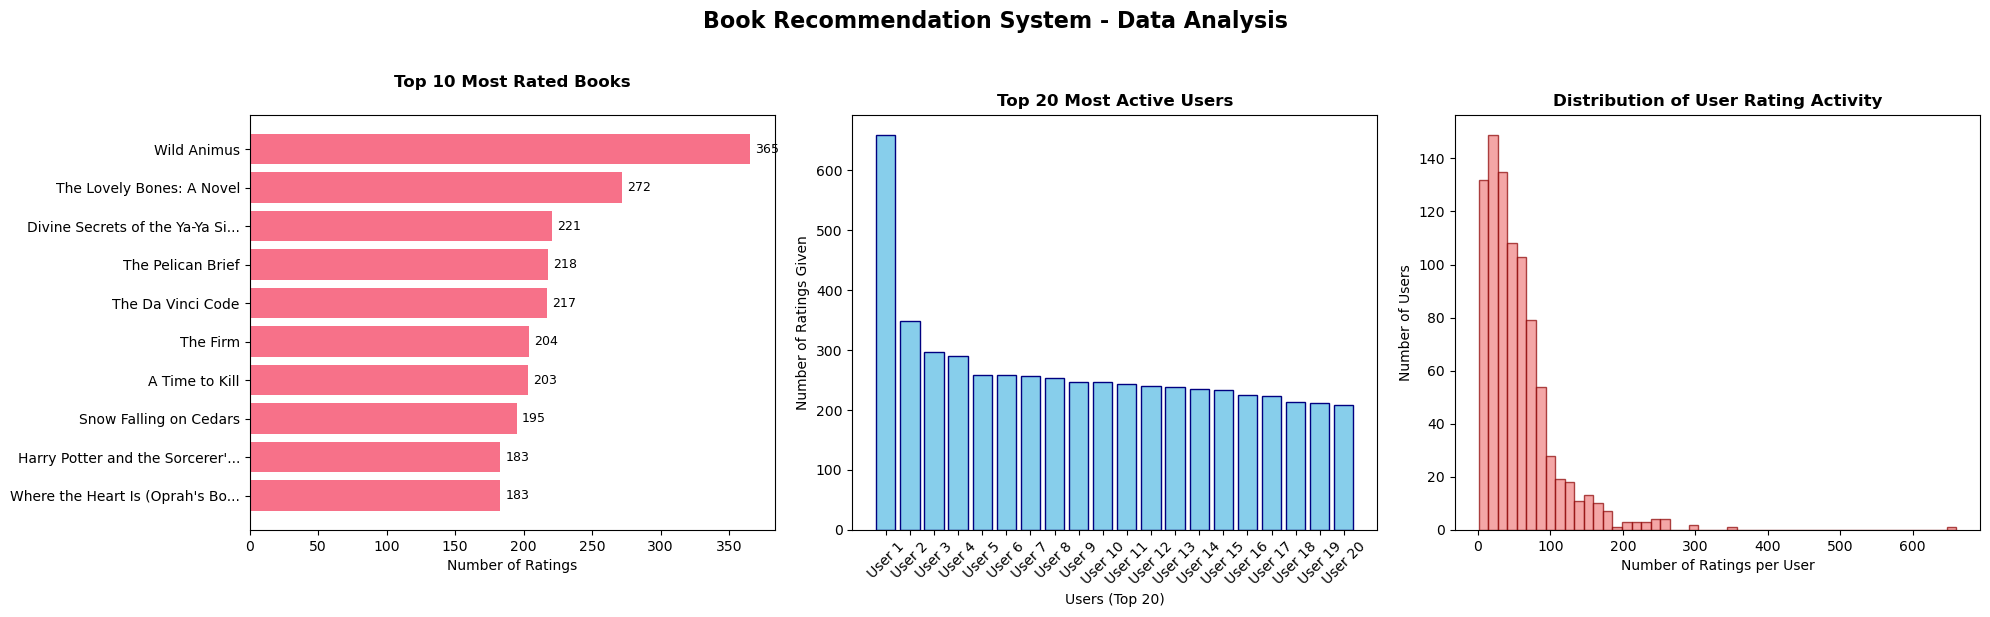

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Book Recommendation System - Data Analysis', fontsize=16, fontweight='bold', y=1.02)

plt.sca(axes[0])
try:
    isbn_rating_counts = df_ratings_rm['ISBN'].value_counts().head(10)
    
    top_books_titles = []
    top_books_ratings = []
    
    for isbn, count in isbn_rating_counts.items():
        book_match = titles[titles['book_id'] == isbn]
        if not book_match.empty:
            book_title = book_match.iloc[0]['title']
            top_books_titles.append(book_title)
            top_books_ratings.append(count)
        else:
            top_books_titles.append(f"ISBN: {isbn}")
            top_books_ratings.append(count)
    
    plt.barh(range(len(top_books_ratings)), top_books_ratings)
    plt.yticks(range(len(top_books_titles)), [title[:30] + '...' if len(title) > 30 else title 
                                          for title in top_books_titles])
    plt.xlabel('Number of Ratings')
    plt.title('Top 10 Most Rated Books', fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    
    for i, v in enumerate(top_books_ratings):
        plt.text(v + max(top_books_ratings)*0.01, i, str(v), va='center', fontsize=9)
        
except Exception as e:
    plt.text(0.5, 0.5, f'Error loading data:{str(e)}', 
             ha='center', va='center', transform=axes[0].transAxes, fontsize=10)
    plt.title('Top 10 Most Rated Books', fontweight='bold')

try:
    if 'User-ID' in df_ratings_rm.columns:
        user_rating_counts = df_ratings_rm['User-ID'].value_counts()
        
        plt.sca(axes[1])
        top_users = user_rating_counts.head(20)
        plt.bar(range(len(top_users)), top_users.values, color='skyblue', edgecolor='navy')
        plt.xticks(range(len(top_users)), [f'User {i+1}' for i in range(len(top_users))], rotation=45)
        plt.xlabel('Users (Top 20)')
        plt.ylabel('Number of Ratings Given')
        plt.title('Top 20 Most Active Users', fontweight='bold')
        
        plt.sca(axes[2])
        plt.hist(user_rating_counts.values, bins=50, color='lightcoral', edgecolor='darkred', alpha=0.7)
        plt.xlabel('Number of Ratings per User')
        plt.ylabel('Number of Users')
        plt.title('Distribution of User Rating Activity', fontweight='bold')
        
        
except Exception as e:
    print(f"User data not available or error: {e}")

plt.tight_layout()
plt.show()